# Object Detection w/ YOLOv2 (Darknet -> Caffe)
This tutorial demonstrates the steps required to prepare and deploy a trained Darknet model for FPGA acceleration  
We will prepare a trained YOLO v2 model, and then run a single detection.  

## Introduction
You only look once (YOLO) is a state-of-the-art, real-time object detection algorithm.  
The algorithm was published by Redmon et al. in 2016 via the following publications:
[YOLOv1](https://arxiv.org/abs/1506.02640),
[YOLOv2](https://arxiv.org/abs/1612.08242).  
The same author has already released YOLOv3, and some experimental tiny YOLO networks. We focus on YOLOv2.  
This application requires more than just simple classification. The task here is to detect the presence of objects, and localize them within a frame.  
Please refer to the papers for full algorithm details, and/or watch [this.](https://www.youtube.com/watch?v=9s_FpMpdYW8) 
In this tutorial, the network was trained on the 80 class [COCO dataset.](http://cocodataset.org/#home)

## Background
The authors of the YOLO papers used their own programming framework called "Darknet" for research, and development. 
The framework is written in C, and was [open sourced.](https://github.com/pjreddie/darknet)
Additionally, they host documentation, and pretrained weights [here.](https://pjreddie.com/darknet/yolov2/)
Currently, the Darknet framework is not supported by Xilinx's ML Suite.
Additionally, there are some aspects of the YOLOv2 network that are not supported by the Hardware Accelerator, such as the reorg layer. For these reasons the network was modified, retrained, and converted to caffe. In this tutorial we will run the network accelerated on an FPGA using 8b quantized weights and a hardware kernel implementing a 96x32 systolic array with 5MB of image RAM. All convolutions/pools are accelerated on the FPGA fabric, while the final sigmoid, softmax, and non-max suppression functions are executed on the CPU.  

### Network Manual Modifications (Implemented directly in Darknet)
To accommodate FPGA acceleration, two modifications are required for the YOLOv2 network, and then retraining must occur: 
* "reorg" layer a.k.a. "space_to_depth" layer replaced by MAX POOL (W/H Dimensionality is maintained)
  * The reorg layer does not appreciably improve accuracy, and incurrs costly data movement penalties.
  * increasing the output channels of the convolution preeceding reorg and converting reorg to max pool preserves the         dimensionality required for downstream layers.
  
  ``` 
  # increasing output channels of the convolution preserves the same channels in the downstream relationships
  [convolutional]
  batch_normalize=1
  size=1
  stride=1
  pad=1
  #filters=64
  filters=256
  activation=leaky
  
  # Converting below layer to maxpool to preserve downstream HxW relationships
  # [reorg]
  # stride=2
  [maxpool]
  size=2
  stride=2
  ```

# Model Preparation (Offline Process, Performed Once):

## Phase 1: Setup (Before Running Notebook)
    * source $MLSUITE_ROOT/overlaybins/setup.sh

## Phase 2: Convert to Caffe
    * Xilinx provides a darknet2caffe.py python script  
    * The script will take as arguments a darknet *.cfg file, and a darknet *.weights file, then generate a *.prototxt and a *.caffemodel.  
    * This is necessary for integration into the downstream components of ML-Suite.  
                                                                          

## Phase 3: Compile The Model  
    * A Network Graph (prototxt) and a Weights Blob (caffemodel) are compiled
    * The network is optimized
    * FPGA Instructions are generated
      * These instructions are required to run the network in "one-shot", and minimize data movement

## Phase 4: Quantize The Model
    * The Quantizer will generate a json file holding scaling parameters for quantizing floats to INT16 or INT8
    * This is required, because FPGAs will take advantage of Fixed Point Precision, to achieve faster inference
      * While floating point precision is useful in the model training scenario
          It is not required for high speed, high accuracy inference
    
 

### Step 1. Import required packages, check environment.

In [1]:
import os,sys,cv2,timeit
from __future__ import print_function

from matplotlib import pyplot as plt
%matplotlib inline


# Bring in Xilinx ML-Suite Compiler and Quantizer
from xfdnn.tools.compile.bin.xfdnn_compiler_caffe import CaffeFrontend as xfdnnCompiler
from decent import CaffeFrontend as xfdnnQuantizer
import xfdnn.rt.xdnn as pyxfdnn
import xfdnn.rt.xdnn_io as pyxfdnn_io

# Bring in darknet2caffe functions
from darknet2caffe import *
from get_decent_q_prototxt import *

# Bring in Non-Max Suppression 
import nms

# Bring in utility for drawing boxes
from yolo_utils import generate_colors, draw_boxes

# Ignore some warnings from the quantizer
import warnings
warnings.simplefilter("ignore", UserWarning)

# Environment Variables ("source overlaybins/setup.sh")
import os
HOME = os.getenv("HOME","/home/mluser")
MLSUITE_ROOT = os.getenv("MLSUITE_ROOT","../")
MLSUITE_PLATFORM = os.getenv("MLSUITE_PLATFORM","alveo-u200")
print("Running w/ MLSUITE_ROOT: %s" % MLSUITE_ROOT)
print("Running w/ MLSUITE_PLATFORM: %s" % MLSUITE_PLATFORM)
os.environ['LIBXDNN_PATH'] = MLSUITE_ROOT+"/xfdnn/rt/xdnn_cpp/lib/libxfdnn.so.v3"
print("Current working directory: %s" % os.getcwd())
print("Running on host: %s" % os.uname()[1])
print("Running w/ LD_LIBRARY_PATH: %s" %  os.environ["LD_LIBRARY_PATH"])
print("Running w/ XILINX_OPENCL: %s" %  os.environ["XILINX_OPENCL"])
print("Running w/ XCLBIN_PATH: %s" %  os.environ["XCLBIN_PATH"])
print("Running w/ PYTHONPATH: %s" %  os.environ["PYTHONPATH"])
print("Running w/ SDACCEL_INI_PATH: %s" %  os.environ["SDACCEL_INI_PATH"])

id = !whoami

print ("Running as user: %s" % id[0])
# Make sure there is no error in this cell
# The xfDNN runtime depends upon the above environment variables

['/opt/arun/MLsuite_fork/xfdnn/rt', '/opt/arun/MLsuite_fork/xfdnn/tools/compile/quantz', '/opt/arun/MLsuite_fork/xfdnn/tools/compile/partitioning', '/opt/arun/MLsuite_fork/xfdnn/tools/compile/pickle', '/opt/arun/MLsuite_fork/xfdnn/tools/compile/parallel', '/opt/arun/MLsuite_fork/xfdnn/tools/compile/bin', '/opt/arun/MLsuite_fork/xfdnn/tools/compile/version', '/opt/arun/MLsuite_fork/xfdnn/tools/compile/weights', '/opt/arun/MLsuite_fork/xfdnn/tools/compile/optimizations', '/opt/arun/MLsuite_fork/xfdnn/tools/compile/network', '/opt/arun/MLsuite_fork/xfdnn/tools/compile/memory', '/opt/arun/MLsuite_fork/xfdnn/tools/compile/graph', '/opt/arun/MLsuite_fork/xfdnn/tools/compile/codegeneration', '/opt/arun/MLsuite_fork/xfdnn/tools/compile/bin/../quantz', '/opt/arun/MLsuite_fork/xfdnn/tools/compile/bin/../scripts', '/opt/arun/MLsuite_fork/xfdnn/tools/compile/bin/../partitioning', '/opt/arun/MLsuite_fork/xfdnn/tools/compile/bin/../examples', '/opt/arun/MLsuite_fork/xfdnn/tools/compile/bin/../compil

Running as user: mluser


### Step 2. Use a config dictionary to pass parameters. Load an image from disk.

Here, we will setup and use a config dictionary to simplify handling of the arguments. For this example, we will attempt to classify a picture of a man standing on a horse. Image courtesy of openimages.


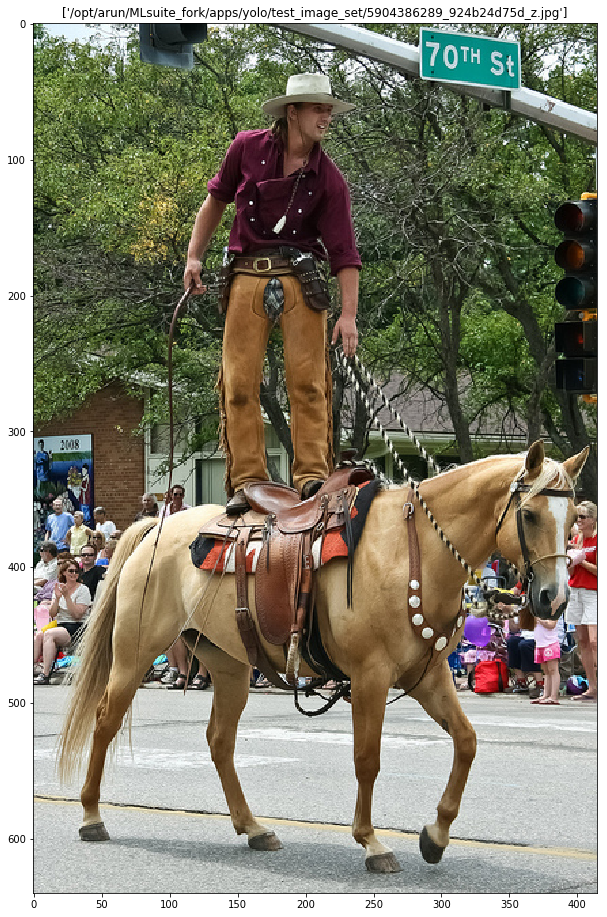

In [2]:
config = {}


# Image of interest (Must provide as a list)
config["images"] = [MLSUITE_ROOT+"/apps/yolo/test_image_set/5904386289_924b24d75d_z.jpg"]
config['in_shape'] = [3, 608, 608]
img = cv2.imread(config["images"][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.rcParams['figure.figsize'] = [24.0,16.0]
plt.imshow(img)
plt.title(config["images"])
plt.show()

### Step 3. Run darknet2caffe script.

Here, we need to convert the model from darknet to caffe. The below cell will create a prototxt, and a caffemodel in the ./work directory. Such a translation will be necessary for any model defined in darknet.

In [3]:
# Run the darknet2caffe python script which will convert a yolov2 darknet model to a caffe model
# This script additionally will remove batchnorm layers, by merging the parameters
# This step is intentionally performed upstream of the compiler due to Darknet's non-conforming implementation of 
#   batch normalization

config["prototxt"] = "./work/yolov2.prototxt" 
config["caffemodel"] = "./work/yolov2.caffemodel"

darknet2caffe(MLSUITE_ROOT+"/models/darknet/yolov2/fp32/yolo.xdnn.nobn.608.cfg",
              MLSUITE_ROOT+"/models/darknet/yolov2/fp32/yolo.xdnn.nobn.weights",
               config["prototxt"],
               config["caffemodel"])

block:OrderedDict([('type', 'route'), ('layers', '-9')])
block:OrderedDict([('type', 'route'), ('layers', '-1,-4')])
from_layer: ['-1', '-4']
prev_layer_id1: 28
prev_layer_id2: 25
layer_id: 29
concat_layer: OrderedDict([('name', 'layer29-concat'), ('type', 'Concat'), ('bottom', ['layer28-maxpool', 'layer25-conv']), ('top', 'layer29-concat')])
net
convolutional
('loading conv name', 'layer1-conv')
maxpool
convolutional
('loading conv name', 'layer3-conv')
maxpool
convolutional
('loading conv name', 'layer5-conv')
convolutional
('loading conv name', 'layer6-conv')
convolutional
('loading conv name', 'layer7-conv')
maxpool
convolutional
('loading conv name', 'layer9-conv')
convolutional
('loading conv name', 'layer10-conv')
convolutional
('loading conv name', 'layer11-conv')
maxpool
convolutional
('loading conv name', 'layer13-conv')
convolutional
('loading conv name', 'layer14-conv')
convolutional
('loading conv name', 'layer15-conv')
convolutional
('loading conv name', 'layer16-conv')
c

### Step 4. Create Quantizer Instance and pass arguments.

Here, we will quantize the model. The inputs are model train_val prototxt, model weights, number of test iterations and calibration iterations. The output is quantized prototxt, weights, and quantize_info.txt and will be generated in the quantize_results/ directory.

The Quantizer will generate a json file holding scaling parameters for quantizing floats to INT8 This is required, because FPGAs will take advantage of Fixed Point Precision, to achieve accelerated inference

In [4]:
#We need to generate a train val prototxt from depoly prototxt
get_train_prototxt_deephi("caffe", 
                          config["prototxt"] , 
                          "train_val.prototxt",
                          MLSUITE_ROOT+"/apps/yolo/images.txt", 
                          MLSUITE_ROOT+"/apps/yolo/test_image_set/")

(608L, 608L)
<class 'caffe.net_spec.NetSpec'>
layer {
  name: "data"
  type: "ImageData"
  top: "data"
  top: "label"
  include {
    phase: TRAIN
  }
  transform_param {
    mirror: false
    yolo_height: 608
    yolo_width: 608
  }
  image_data_param {
    source: "/opt/arun/MLsuite_fork/apps/yolo/images.txt"
    batch_size: 1
    shuffle: false
    root_folder: "/opt/arun/MLsuite_fork/apps/yolo/test_image_set/"
  }
}

('before\n', name: "Darknet2Caffe"
layer {
  name: "data"
  type: "Input"
  top: "data"
  input_param {
    shape {
      dim: 1
      dim: 3
      dim: 608
      dim: 608
    }
  }
}
layer {
  name: "layer1-conv"
  type: "Convolution"
  bottom: "data"
  top: "layer1-conv"
  convolution_param {
    num_output: 32
    bias_term: true
    pad: 1
    kernel_size: 3
    stride: 1
  }
}
layer {
  name: "layer1-act"
  type: "ReLU"
  bottom: "layer1-conv"
  top: "layer1-conv"
}
layer {
  name: "layer2-maxpool"
  type: "Pooling"
  bottom: "layer1-conv"
  top: "layer2-maxpool"


In [5]:
# Use a config dictionary to pass parameters to the compiler
# Quantizer Arguments
#config["outmodel"] = Defined in Step 4 # String for naming intermediate prototxt, caffemodel
def Quantize(prototxt,caffemodel,calib_iter=1):
    
    quantizer = xfdnnQuantizer(
        model=prototxt,
        weights=caffemodel,
        calib_iter=calib_iter,
    )
    
    quantizer.quantize()

In [6]:
Quantize("train_val.prototxt",config["caffemodel"])

### Step 5. Define an xfdnnCompiler instance and pass it arguments.  
The compiler takes in the quantizer outputs from the previous step (prototxt, weights, quantize_info) and outputs a compiler.json and quantizer.json.

* A Network Graph (prototxt) and a Weights Blob (caffemodel) are compiled
* The network is optimized
* FPGA Instructions are generated
  

In [7]:
# Some standard compiler arguments - PLEASE DONT TOUCH
def Getopts():
    return {
            "bytesperpixels":1,
            "dsp":96,
            "memory":9,
            "ddr":256,
            "cpulayermustgo":True,
            "mixmemorystrategy":True,
            "pipelineconvmaxpool":True,
            "usedeephi":True,
    }

In [8]:
def Compile(prototxt="quantize_results/deploy.prototxt",\
            caffemodel="quantize_results/deploy.caffemodel",\
            quantize_info="quantize_results/quantize_info.txt"):
    
    compiler = xfdnnCompiler(        
        networkfile=prototxt,
        weights=caffemodel,
        quant_cfgfile=quantize_info,
        generatefile="work/compiler",
        quantz="work/quantizer",
        **Getopts()
    )
    
    compiler.compile()


In [9]:
Compile()
config["quantizecfg"] = "work/quantizer.json"
config["netcfg"]      = "work/compiler.json"
config["weights"]     = "work/deploy.caffemodel_data.h5"

Network: quantize_results/deploy.prototxt
GenerateCode: work/compiler
Weights: quantize_results/deploy.caffemodel
PngFile: None
ConcatStrategy: None
Strategy: all
ScheduleFile: None
DDR: 256
DSP: 96
Verbose: False
FromTF: True
Memory: 9
Phase: TEST
RankDir: BT
Start compiling quantize_results/deploy.prototxt

**************************************************
* BUILDING DATA FLOW GRAPH
**************************************************
Writing processed protoxt to /tmp/tmpNKwch7:deploy.prototxt
loading network Net /tmp/tmpNKwch7:deploy.prototxt quantize_results/deploy.caffemodel 1 <type 'str'> <type 'str'> <type 'int'>
Exception 'Layer' object has no attribute 'pooling_param' <caffe._caffe.Layer object at 0x7f0a6cee5a28>
Exception 'Layer' object has no attribute 'pooling_param' <caffe._caffe.Layer object at 0x7f0a6cee5b90>
Exception 'Layer' object has no attribute 'pooling_param' <caffe._caffe.Layer object at 0x7f0a6cee5ed8>
Exception 'Layer' object has no attribute 'pooling_param' <ca

Removed PreReLU? 0 []

**************************************************
* Concat Alignment verification to mod 8             
**************************************************
**************************************************
* CPU Layer will be REMOVED
**************************************************
* CPU Layer schedule

{1} -|-0 name data type Input fpga False bottoms [] [Extras None]-  Past [] -> Future []
{1} -|-1 name layer1-conv type Convolution fpga True bottoms [u'data'] [Extras [u'layer1-act']]-  Past [] -> Future [u'layer1-act']
{1} -|-2 name layer2-maxpool type Pooling fpga True bottoms [u'layer1-conv'] [Extras None]-  Past [] -> Future []
{1} -|-3 name layer3-conv type Convolution fpga True bottoms [u'layer2-maxpool'] [Extras [u'layer3-act']]-  Past [] -> Future [u'layer3-act']
{1} -|-4 name layer4-maxpool type Pooling fpga True bottoms [u'layer3-conv'] [Extras None]-  Past [] -> Future []
{1} -|-5 name layer5-conv type Convolution fpga True bottoms [u'layer4-maxpool

layer params prelu layer24-conv 0
layer params prelu layer8-maxpool None
layer params prelu layer20-conv 0
layer params prelu layer23-conv 0
layer params prelu layer4-maxpool None
layer params prelu layer28-maxpool None
layer params prelu layer13-conv 0
layer params prelu layer25-conv 0
layer params prelu layer12-maxpool None
layer params prelu layer18-maxpool None
layer params prelu data None
layer params prelu layer17-conv 0
layer params prelu layer2-maxpool None
layer params prelu layer31-conv_output None
layer params prelu layer10-conv 0
layer params prelu layer14-conv 0
layer params prelu layer30-conv 0
layer params prelu layer31-conv None
layer params prelu layer19-conv 0
layer params prelu layer6-conv 0
layer params prelu layer15-conv 0
layer params prelu layer22-conv 0

{1} -|-0 name data type Input fpga True bottoms [] [Extras [u'layer1-conv', u'layer1-act']]-  Past [] -> Future []
{1} -|-1 name layer2-maxpool type Pooling fpga True bottoms [u'data'] [Extras [u'layer3-conv', u

Input & outputs data ['Input']
	 []
	 [u'"layer2-maxpool"']
Input & outputs layer31-conv_output ['Output']
	 [u'"layer31-conv"']
	 []
outs 1
inss 1
 ?????  <hardware.DDR instance at 0x7f0a8e5aaef0> <hardware.DDR instance at 0x7f0a6dc7ccf8>
Alive  layer31-conv_output_blob BlobInformation(size=173280.0, name=u'layer31-conv_output_blob', memory=MemoryAllocation(start=0, end=656640.0, size=656640.0, extra=[1], strategy=[], layout=1, timestamp=1, slice=1, shapes=SizeType(batches=1, channels=425, height=19, width=19), replication=Replication(full_sect_num=5, repl_sect_num=0, repl_unit_num=0, repl_unit_width=0, channels_division=0), written=False, specifier='Output', IO=True), dag=ColorForDAG(active=[3], schedule=-1, forward=[], backward=[26], extra=None, hook=[]), layer_type=['layer'], data_movement_operations=[], data_movement_operation_costs=[])
Alive  data_blob BlobInformation(size=35487744.0, name=u'data_blob', memory=MemoryAllocation(start=0, end=11829248.0, size=11829248.0, extra=[1], 

Pooling <function overlap_priority at 0x7f0a8e5e68c0>
AM_BUFF_1 9437184 2 4718592 49152 MemoryAllocation(start=0, end=11829248.0, size=35487744, extra=[1], strategy=['tops'], layout=1, timestamp=28812, slice=1, shapes=SizeType(batches=1, channels=3, height=608, width=608), replication=Replication(full_sect_num=0, repl_sect_num=1, repl_unit_num=12, repl_unit_width=8, channels_division=[3]), written=True, specifier='Input', IO=True)
PIPELINE POOL S SizeType(batches=0, channels=0, height=2, width=2) SizeType(batches=1, channels=32, height=106, width=112)
V3 Tile layer2-maxpool (4L, -1139712)
ddr_to_am REP V BestReplication(FSN=0, RSN=1, RUN=3, RUW=32, FSC=0L, RSC=3) SpaceAndTime(space=8871936, time=51767, replication=Replication(full_sect_num=0, repl_sect_num=1, repl_unit_num=3, repl_unit_width=32, channels_division=[32]))
AM_BUFF_1 9437184 6 1572864 16384 MemoryAllocation(start=0, end=2957312.0, size=8871936, extra=[1], strategy=['tops'], layout=1, timestamp=51767, slice=1, shapes=SizeTy

Processing weights for 27 schedule steps: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
Done writing weights.
SUCCESS True


# Model Deployment (Online Process, Typically Performed Iteratively):  
    

## Phase 4. Deploy The Model.
Next, we need to utilize the xfDNN APIs to deploy our network to the FPGA. We will walk through the deployment APIs, step by step: 
1. Open a handle for FPGA communication
2. Load weights, biases, and quantization parameters to the FPGA DDR
3. Allocate storage for FPGA inputs (such as images to process)
4. Allocate storage for FPGA outputs (the activation of the final layer run on the FPGA)
5. Execute the network
6. Run region layer on the CPU
7. Run non-max suppression on the CPU
8. Print the result 
9. When you are done, close the handle to the FPGA

First, we will create the handle to communicate with the FPGA and choose which FPGA overlay to run the inference on. For this lab, we will use overlay_4. You can learn about other overlay options in the ML Suite Tutorials [here][].  

[here]: https://github.com/Xilinx/ml-suite
        
### Step 6. Open a handle for FPGA communication.

In [10]:
# Create a handle with which to communicate to the FPGA
# The actual handle is managed by pyxfdnn

# Chosen Hardware Overlay
config["xclbin"] = MLSUITE_ROOT+"/overlaybins/"+MLSUITE_PLATFORM+"/overlay_4.xclbin"
## NOTE: If you change the xclbin, we likely need to change some arguments provided to the compiler
## Specifically, the DSP array width, and the memory arguments

config["xfdnn_library"] = MLSUITE_ROOT+"/xfdnn/rt/xdnn_cpp/lib/libxfdnn.so.v3" # Library functions called by pyXFDNN

config['xdnn_handle'], handles = pyxfdnn.createHandle(config['xclbin'], "kernelSxdnn_0" )
if config['xdnn_handle'] != 0:
    print("ERROR: Unable to create handle to FPGA")
    

else:
    print("INFO: Successfully created handle to FPGA")
    
# If this step fails, most likely the FPGA is locked by another user, or there is some setup problem with the hardware
# For instance the xclbin could have been built for the wrong DSA/shell

INFO: Successfully created handle to FPGA


### Step 7. Apply quantization scaling and transfer model weights to the FPGA. 

In [11]:
# Quantize, and transfer the weights to FPGA DDR

# config["datadir"] = "work/" + config["caffemodel"].split("/")[-1]+"_data" # From Compiler
config["scaleA"] = 10000 # Global scaler for weights (Must be defined, although not used)
config["scaleB"] = 30 # Global scaler for bias (Must be defined, although not used)
config["PE"] = 0 # Run on Processing Element 0 - Different xclbins have a different number of Elements
config['batch_sz']=1
#(weightsBlob, fcWeight, fcBias ) = pyxfdnn_io.loadWeights(config)

# Note that this function returns pointers to weights corresponding to the layers that will be implemented in the CPU

### Step 8. Allocate space in host memory for inputs, load images from disk, and prepare images. 

In [12]:
#initialize network
fpgaRT = pyxfdnn.XDNNFPGAOp(handles, config)
fpgaInput = fpgaRT.getInputs()
fpgaOutput = fpgaRT.getOutputs()

firstInput = fpgaInput.itervalues().next()
firstOutput = fpgaOutput.itervalues().next()
    
# Allocate space in host memory for inputs, Load images from disk



In [13]:
firstInput[0,...], s = pyxfdnn_io.loadYoloImageBlobFromFile(img,  config['in_shape'][1], config['in_shape'][2])

### Step 9. Set parameters for outputs.

In [14]:
# Allocate space in host memory for outputs

# The output of a yolo network is more complex than most networks.

# In YOLOv2 the input image is square, and it is divided into grid cells of 32 pixels each.
# For example, a 608x608 image would yield a volume with HxW = 19x19. Where 19 = 608/32
#              a 224x224 image would yield a volume with HxW = 7x7
out_h = out_w = config["in_shape"][1] / 32

# For each grid cell in the input image, YOLOv2 considers the possibility of 5 objects being present (Anchor Boxes)
#   For each anchor box, YOLOv2 computes
#   - The probability that there is an object in the anchor box - 1 element
#   - The x,y,w,h coordinates of a bounding box (centroid and width height of box) - 4 elements
#   - The class probabilities (Number of classes depends on dataset) We use MS COCO which has 80 classes - 80 elements
anchor_boxes = 5
objectness   = 1
coordinates  = 4
classes      = 80
out_c        = objectness + coordinates + classes

# Number of elements in the activation of the last layer ran on the FPGA
config["fpgaoutsz"] = anchor_boxes * out_c * out_h * out_w 


          

### Step 10. Write optimized micro-code to the xDNN Processing Engine on the FPGA. Execute the network.

In [15]:
# Write FPGA Instructions to FPGA and Execute the network!
startTime = timeit.default_timer()
fpgaRT.execute(fpgaInput, fpgaOutput, config['PE'])
elapsedTime = timeit.default_timer() - startTime
           
# Only showing time for second run because first is loading script
#log.info("\nTotal FPGA: %f ms" % (elapsedTime*1000))
#log.info("Image Time: (%f ms/img):" % (elapsedTime*1000/config['batch_sz']))
print("Time to load microcode and execute %d ms" % (elapsedTime*1000))
    
# Note that the time printed here is the time to transfer microcode to the FPGA + the time to execute
# Iterative calls to this cell will produce the real latency number


Time to load microcode and execute 39 ms


### Step 11. Execute the YOLOv2 region layer on the CPU.
The region layer requires the sigmoid function to be applied to the X/Y coordinates of each prediction, and the box confidence. It also requires the softmax to be computed across all class scores in each anchor box. Here we use numpy to acheive this.

In [16]:
# Functions Required for implementing YOLOv2 region layer
# Implemented using numpy in a numerically stable manner
def sigmoid(x):
    pos_mask = (x >= 0)
    neg_mask = (x < 0)
    z = np.zeros_like(x)
    z[pos_mask] = np.exp(-x[pos_mask])
    z[neg_mask] = np.exp(x[neg_mask])
    top = np.ones_like(x)
    top[neg_mask] = z[neg_mask]
    return top / (1 + z)

def softmax(x):
    e_x = np.exp(x-np.max(x))
    return (e_x)/(e_x.sum(axis=0,keepdims=True))

startTime = timeit.default_timer()


# Apply sigmoid to 1st, 2nd, 4th channel for all anchor boxes
firstOutput = firstOutput.reshape(anchor_boxes,out_c,out_h,out_w)
firstOutput[:,0:2,:,:] = sigmoid(firstOutput[:,0:2,:,:]) # (X,Y) Predictions
firstOutput[:,4,:,:]   = sigmoid(firstOutput[:,4,:,:])   # Objectness / Box Confidence

# Apply softmax on the class scores foreach anchor box
for box in range(anchor_boxes):
    firstOutput[box,5:,:,:]  = softmax(firstOutput[box,5:,:,:])
    
elapsedTime = timeit.default_timer() - startTime
print(elapsedTime*1000, "ms")

2.90703773499 ms


### Step 12. Execute NMS on the CPU.
Non-Max Suppression is the algorithim used to filter out redundant predictions. For instance, yolo could have produced multiple bounding boxes for the same object. Additionally, predictions made with low confidence are thrown out.
We have encapsulated some C code for implementing NMS in a python wrapper.

In [17]:
# Perform Non-Max Suppression
# Non-Max Suppression filters out detections with a score lesser than 0.24
# Additionally if there are two predections with an overlap > 30%, the prediction with the lower score will be filtered
scorethresh = 0.24
iouthresh = 0.3
print(s)
bboxes = nms.do_baseline_nms(firstOutput.flat,
                             s[1],
                             s[0],
                             config['in_shape'][2],
                             config['in_shape'][1],
                             out_w,
                             out_h,
                             anchor_boxes,
                             classes,
                             scorethresh,
                             iouthresh)

(640, 415, 3)


### Step 13. Print out results.
After NMS all operations are complete. Now we must print the results, and we can draw the detections on the original image for reference.

Obj 0: traffic light\ class id = 9
	 score = 0.592441
	 (xlo,ylo) = (373,200)
	 (xhi,yhi) = (414,121)
Obj 1: person\ class id = 0
	 score = 0.241847
	 (xlo,ylo) = (16,419)
	 (xhi,yhi) = (55,357)
Obj 2: person\ class id = 0
	 score = 0.529713
	 (xlo,ylo) = (389,496)
	 (xhi,yhi) = (414,349)
Obj 3: person\ class id = 0
	 score = 0.589256
	 (xlo,ylo) = (0,479)
	 (xhi,yhi) = (30,418)
Obj 4: person\ class id = 0
	 score = 0.557791
	 (xlo,ylo) = (319,487)
	 (xhi,yhi) = (353,426)
Obj 5: person\ class id = 0
	 score = 0.436093
	 (xlo,ylo) = (364,492)
	 (xhi,yhi) = (402,413)
Obj 6: person\ class id = 0
	 score = 0.817116
	 (xlo,ylo) = (96,370)
	 (xhi,yhi) = (251,20)
Obj 7: horse\ class id = 17
	 score = 0.775760
	 (xlo,ylo) = (23,627)
	 (xhi,yhi) = (396,277)
oimage = 5904386289_924b24d75d_z.jpg
Saving new image with bounding boxes drawn as ./work/5904386289_924b24d75d_z.jpg


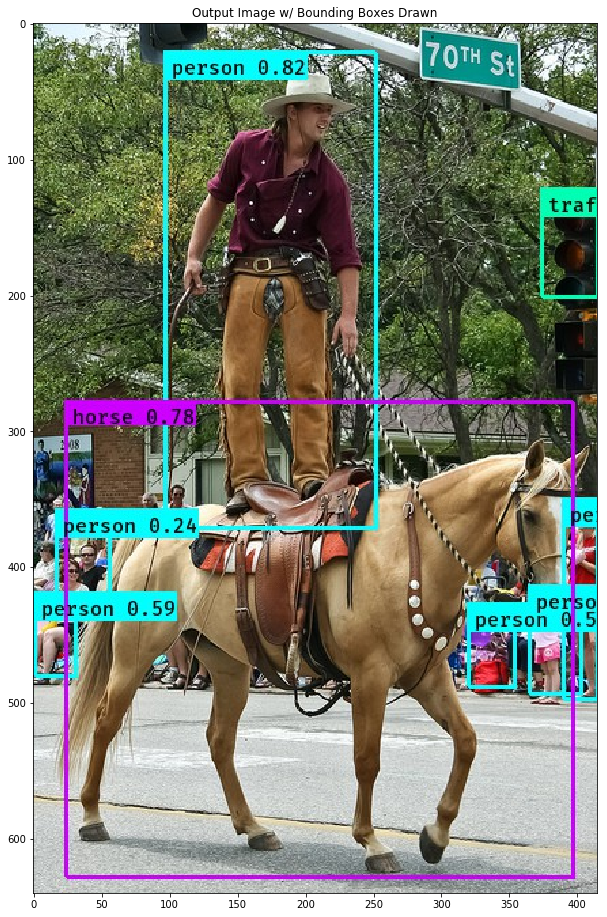

In [18]:
# Create a list of class labels given a file containing the coco dataset classes
with open(MLSUITE_ROOT+"/apps/yolo/coco.names") as f:      
    namez = f.readlines()      
    names = [x.strip() for x in namez]
    
# Lets print the detections our model made
for j in range(len(bboxes)):
    print("Obj %d: %s\ class id = %d" % (j, names[bboxes[j]['classid']], bboxes[j]['classid']))
    print("\t score = %f" % (bboxes[j]['prob']))
    print("\t (xlo,ylo) = (%d,%d)" % (bboxes[j]['ll']['x'], bboxes[j]['ll']['y']))
    print("\t (xhi,yhi) = (%d,%d)" % (bboxes[j]['ur']['x'], bboxes[j]['ur']['y']))
    
# Given the detection results above, lets draw our findings on the original image, and display it
colors = generate_colors(classes)
draw_boxes(config["images"][0],bboxes,names,colors,"./work",MLSUITE_ROOT+"/apps/yolo/font",False)
outimage = "./work/" + os.path.basename(config["images"][0])
img = cv2.imread(outimage)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.rcParams['figure.figsize'] = [24.0,16.0]
plt.imshow(img)
plt.title("Output Image w/ Bounding Boxes Drawn")
plt.show()

### Step 14. Close the handle.

In [19]:
pyxfdnn.closeHandle()

# C'est fini!